In [1]:
import os
import pandas as pd
import transformers
import torch
import numpy as np
from Code.utinity import *
from Code.models import *

from tqdm import tqdm

In [2]:
class LLM_u(LLM):
    def get_attention_matrix(self,outputs):
        A = 0
        for layer in range(len(outputs.attentions)):
            X = outputs.attentions[layer][0].to(torch.float32).cpu().detach().numpy()
            for i in range(len(X)):
                Ai = (X[i] + X[i].T)/2
               
                A = (A+Ai)/2 + abs(A-Ai)/2
       
        A = np.triu(A)
        return A

## 算法设定

以 Llama2 为基础模型，比较现有算法（baseline）和我们设计的算法（ours）

In [3]:
model_name = 'bert'
llm = LLM_u(model_name,load_model=True)
# llm = LLM_u('gpt2',load_model=True)
llm.model_name = model_name + 'uu_test'
solver_baseline = Solver_Baseline(llm)
# solver_ours_v = Solver_Ours(llm, repeat=1, shift=False, attention=True)
# solver_ours_vv = Solver_Ours(llm, repeat=2, shift=False, attention=True)
# solver_ours_vvv = Solver_Ours(llm, repeat=3, shift=False, attention=True)
# solver_ours_vvvv = Solver_Ours(llm, repeat=4, shift=False, attention=True)
# solver_ours_vvvvv = Solver_Ours(llm, repeat=5, shift=False, attention=True)
# solvers = [solver_baseline,solver_ours_v,solver_ours_vv,solver_ours_vvv,solver_ours_vvvv,solver_ours_vvvvv]
# solvers = [solver_ours_v,solver_ours_vv,solver_ours_vvv]
solvers = [solver_baseline]

bert 调用成功!


## 算法验证

In [4]:
results = {}
accuracy = {}
# def RunEval(problem,use_temp=True):
def RunEval(problem,use_temp=True):
    results[problem.name] = []
    accuracy[problem.name] = []
    for i,solver in enumerate(solvers):
        # if i == 3:
        #     use_temp = False
        evaluation = Evaluation(problem,solver,later=False,use_temp=use_temp)
        df1,df2 = evaluation.save(filename='result/'+problem.name+'_'+solver.name+'.xlsx')
        results[problem.name].append(df1)
        accuracy[problem.name].append(df2)
    # accuracy[problem.name] = pd.concat([df2,df4],axis=1).T # 添加结果
    return pd.concat(accuracy[problem.name],axis=1).T

### 数据集 1: SLPWC

In [5]:
result = RunEval(problem=Problem("Data/SLPWC_v1.csv",name='SLPWC'))
result

利用 bertuu_test_baseline 计算目标词的向量嵌入：


  0%|          | 0/300 [00:00<?, ?it/s]

没有找到词: emo “emo”是一种与朋克相似的摇滚乐，最初从HardcorePunk(硬核朋克)中派生出来，但包含更为复杂的改编曲，歌词更多触及情感主题。
没有找到词: emo 以后不在朋友圈装emo了，其实我这个长相，根本没有那么多感情问题
没有找到词: emo 明天开学要分班，狠狠emo了。
没有找到词: emo 我emo了，有一瞬间我想过死亡。
保存文件： Temp/temp_embeddings_SLPWC_bertuu_test_baseline.dat


,distance_shift,cos_similarity_shift
bertuu_test_baseline,0.843333,0.853333


In [6]:
# columns = ['model', 'distance_shift', 'cos_similarity_shift']
result.insert(0, 'model', result.iloc[:, 0])
result.drop(result.columns[1], axis=1, inplace=True) 

result

,model,cos_similarity_shift
bertuu_test_baseline,0.843333,0.853333


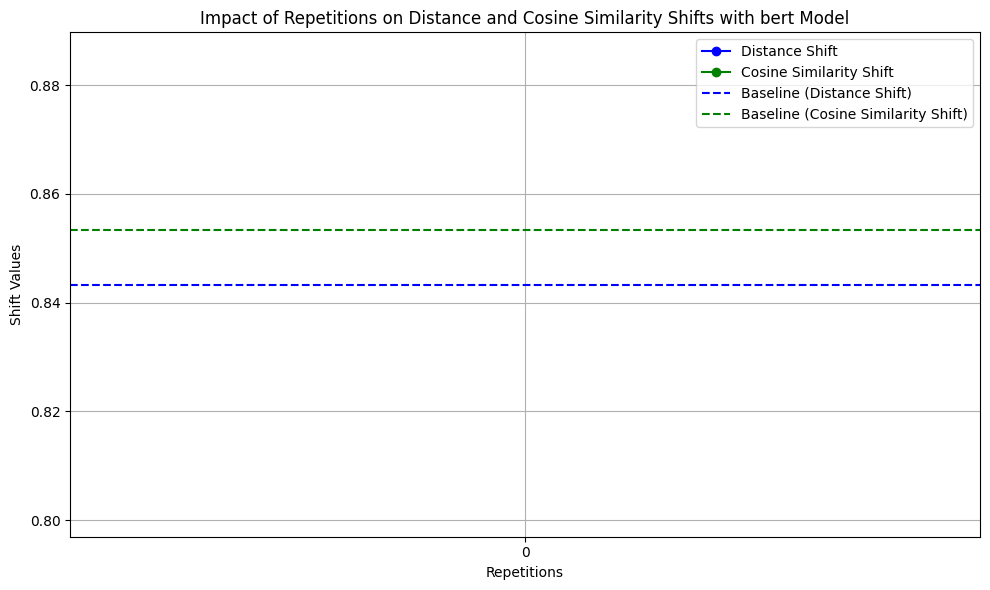

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# 创建 DataFrame
data = {
    "model": [solver.name for solver in solvers],
    "distance_shift": [result.iloc[i, 0] for i in range(len(solvers))],
    "cos_similarity_shift": [result.iloc[i, 1] for i in range(len(solvers))]
}

df = pd.DataFrame(data)

# 添加重复次数列
df['repetitions'] = df['model'].apply(lambda x: 0 if 'baseline' in x else x.count('v') - 1)

# 绘制图表
plt.figure(figsize=(10, 6))

# 绘制欧氏距离和余弦相似度
plt.plot(df['repetitions'][1:], df['distance_shift'][1:], marker='o', color='b', label='Distance Shift')
plt.plot(df['repetitions'][1:], df['cos_similarity_shift'][1:], marker='o', color='g', label='Cosine Similarity Shift')

# 添加 baseline 虚线
baseline_distance = df[df['model'].str.contains('baseline')]['distance_shift'].values[0]
baseline_cosine = df[df['model'].str.contains('baseline')]['cos_similarity_shift'].values[0]
plt.axhline(y=baseline_distance, color='b', linestyle='--', label='Baseline (Distance Shift)')
plt.axhline(y=baseline_cosine, color='g', linestyle='--', label='Baseline (Cosine Similarity Shift)')

# 图表标题和标签'
plt.title('Impact of Repetitions on Distance and Cosine Similarity Shifts with {} Model'.format(model_name))
plt.xlabel('Repetitions')
plt.ylabel('Shift Values')
plt.xticks(df['repetitions'])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 数据集 2: WSD

In [11]:
RunEval(problem=Problem('Data/WSD_v1.csv',name='WSD'))

利用 bertuu_test_baseline 计算目标词的向量嵌入：


  0%|          | 0/862 [00:00<?, ?it/s]

没有找到词: 名称 "君子疾没世而名不称焉。
没有找到词: 那里 这儿瞧瞧,那儿看看,觉得什么都是新鲜的
没有找到词: 龃龉 我们从未和邻居发生过一次龃龉
没有找到词: 龃龉 原来放下一切的放松才是真正的愉快。没有罅隙，没有龃龉，没有试探，没有考量，没有阻碍，像是两个滑蛋从滑梯上滚落，毫无障碍的一生……，可惜，当我们面对这个世界的时候，能放下一切去爱的可能根本不存在
没有找到词: 龃龉 圆凿而方枘兮，吾固知其龃龉而难入
没有找到词: 龃龉 无论是对手足深情的正面展示，还是对手足龃龉的反面剖析，追求手足关系的敦睦乃灌注其中的本质内容
没有找到词: 精简 精选人物
没有找到词: 摄影 骋足则能追风摄景
保存文件： Temp/temp_embeddings_WSD_bertuu_test_baseline.dat


,distance_shift,cos_similarity_shift
bertuu_test_baseline,0.610209,0.607889
